### Import dependencies

In [16]:
import tensorflow as tf
import numpy as np
import cv2
import imghdr
import os
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import Precision, Recall, BinaryAccuracy

### Remove faulty images

In [17]:
data_dir = 'data/project_3/data'
image_extensions = ['jpg', 'jpeg', 'png']

# loop through all our data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # check if the extension fits out list of allowed extensions
            tip = imghdr.what(image_path)
            # if not remove that image
            if tip not in image_extensions:
                print('image not in extensions list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('issue with image {}'.format(image_path))
            os.remove(image_path)

### Load data

In [18]:
# build a dataset on the fly using tf.keras which will automatically create a dataset from our images + resize
data = tf.keras.utils.image_dataset_from_directory('data/project_3/data', batch_size=4)

Found 20 files belonging to 2 classes.


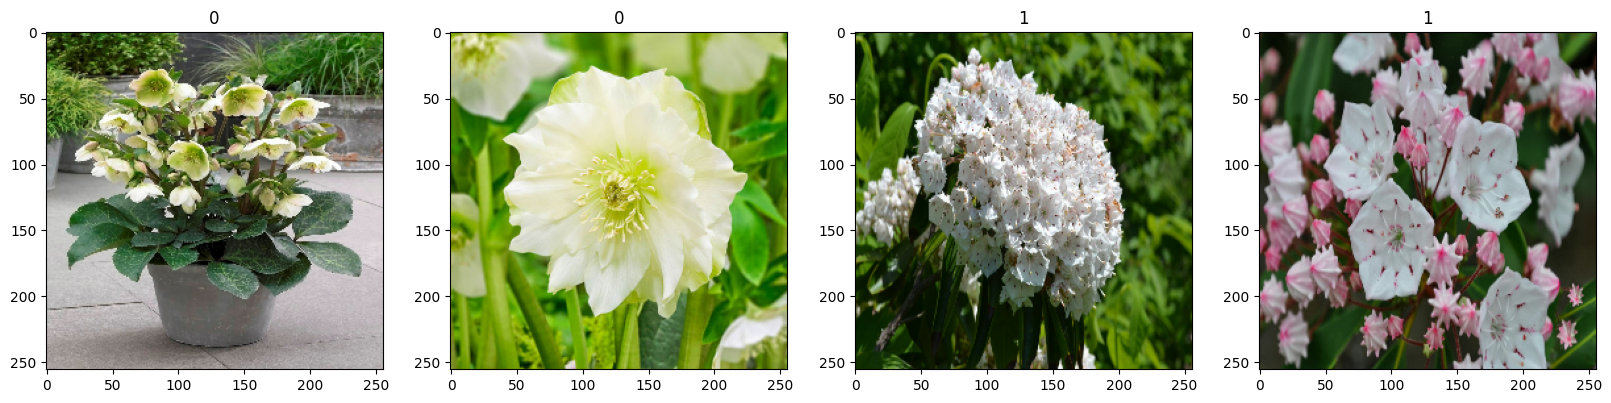

In [19]:
# convert it to a numpy iterator (allows us to access our data pipeline since the data is not preloaded in the memory, it is a generator)
data_iterator = data.as_numpy_iterator()

# get a batch from the iterator
batch = data_iterator.next()

# visualize a batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Pre-proccess data

In [20]:
# scale data using map function
def preprocess_data(x, y):
    x = x/255
    return x, y
data = data.map(preprocess_data)

# convert it to a numpy iterator (allows us to access our data pipeline)
scaled_iterator = data.as_numpy_iterator()

# get a batch from the iterator (allows us to access our data pipeline itself)
batch = scaled_iterator.next()

### Split data

In [ ]:
train_size = int(len(data)*.2)
validation_size = int(len(data)*.3)
test_size = int(len(data)*.1)+1

# use take and skip methods (how many batches we want to allocate for each split we declared)
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test_size = data.skip(train_size+validation_size).take(test_size)

### Create a deep model

In [ ]:
# declare our model using the Sequential api
model = Sequential()
# add layers to the model

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

# similarly add a convolution with 32 filters this time and relu activation
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# similarly add a convolution with 16 filters again this time and relu activation
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# flatten the data down
model.add(Flatten())

# add fully connected Dense layers with 256 neurons and relu activation
model.add(Dense(256, activation='relu'))
# add a final Dense layer with 1 neuron to get a single output that is going to represent 0 or 1 with a sigmoid activation (which will match our classes)
model.add(Dense(1, activation='sigmoid'))

# compile our model with adam optimizer and define what our losses are and an accuracy metric
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

### Train the model

In [ ]:
logdir = 'data/project_3/logs'
# used for logging out the model training as its training, so we can come back and see how it performed at a particular time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# fit the model
hist = model.fit(train, epochs=10, validation_data=validation, callbacks=[tensorboard_callback])

### Plot model performance

In [ ]:
# Plot our model performance using matplotlib
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Plot our model accuracy using matplotlib
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate performance

In [ ]:
# define some instances
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# loop through each batch in our test data and make a prediction
for batch in test_size.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

### Test model on unseen data

In [ ]:
# Test model on some images it has not seen before
img = cv2.imread('data/project_3/test/hellebore_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
resized_img = tf.image.resize(img, (256, 256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [ ]:
# feed into the model (model expects a batch and not a single image, so we need to encapsulate it inside another set of arrays)
np.expand_dims(resized_img, 0)
result = model.predict(np.expand_dims(resized_img/255, 0))
print(result)
if result > 0.5:
    print(f'Predicted class is mountain larual')
else:
    print(f'Predicted class is hellebore')

### Save model

In [ ]:
# Save the model
model.save(os.path.join('data/project_3/models', 'poisonous_flowers.h5'))